# Differential voltage-capacity analysis
Differential voltage-capacity analysis involves the plotting and fitting of a simple model to the low-rate voltage-capacity curve of a battery, using changes in slope and shifts of the curve over a cell's lifetime to estimate degradation modes such as Loss of Lithium Inventory (LLI), Loss of Active Material in the Positive or Negative electrodes (LAM_NE, LAM_PE), and Ohmic Resistance Increase (ORI).

This example demonstrates fitting of half-cell potential curves to the full-cell low-rate capacity check data using the `ampworks` library developed at NREL (Corey Randall, 2024). This is performed by shifting and scaling the half-cell curves, optimally determining the lithiation windows of each individual electrode to fit the shape of the full-cell voltage curve as closely as possible, as well as fitting an estimated ohmic resistance term to account for differences between half-cell and full-cell overpotential.

In [1]:
import pandas as pd
import ampworks as amp
from scipy._lib._util import _RichResult  # Used to make printing pretty

### Import the data
The negative electrode dataframe (df_neg) and positive electrode dataframe (df_pos) must have columns 'soc' and 'voltage'. The full cell dataframe needs 'soc', 'voltage', 'dsoc_dV', and 'dV_dsoc' columns. 

An important note: The fitting routine assumes all dataframe 'soc' columns are in the reference direction of the full cell. Therefore, the negative electrode voltage should decrease as 'soc' increases whereas the positive electrode and full cell voltages should increse as their 'soc' increase.

In [2]:
# Half-cell data would usually only be imported a single time, as the half-cell voltage curve is generally assumed
# to be constant for a given electrode material and not change as the battery degrades.
df_neg = pd.read_csv('Half-cell data/Graphite-Li half-cell.csv')  # negative electrode data
df_pos = pd.read_csv('Half-cell data/NMC-Li half-cell.csv')    # positive electrode data

# Create a fitter instance
# ========================
# The fitter class is used to hold and fit the data. There are a few keyword
# arguments you can see by running help(amp.dqdv.Fitter). Mostly the defaults
# are good, but you might want to change 'cost_terms' to include 'voltage' so
# that an iR offset is fit in addition to the xmin/xmax values of the two
# electrodes. Any keyword argument can also be changed after initializing the
# Fitter instance.
fitter = amp.dqdv.Fitter(df_neg, df_pos)


# Full-cell data from any low rate charge or discharge can be fit (care that the direction of the current is consistent
# between half-cell and full-cell data, i.e., separately fit full-cell charge and discharges with charge and discharge
# half-cell data).
df_cell_BOL = pd.read_csv('Full-cell data/Charge Cb20 Pristine.csv')     # full cell at beginning of life
df_cell_EOL = pd.read_csv('Full-cell data/Charge Cb20 Aged.csv')         # full cell at after some degradation

### Coarse searches
Because fitting routines can get stuck in local minima, it can be important to have a good initial guess. The 'coarse_search()' method helps with this. Given a number of discretizations, it applies a brute force method to find a good initial guess by discretizing the xmin/xmax regions into Nx points, and evaluating all physically realistic locations (i.e., xmax > xmin). The result isn't always great, but is typically good enough to use as a starting value for a more robust fitting routine.

The output from all 'fits' (coarse searches or otherwise) are dictionaries. You can format the dictionary so that it prints well by using the _RichResult class from scipy, as shown below. You can also see what the plot of the best fit looks like using the 'plot()' method, which takes in the fit results.

   fun: 0.40747264355097357
     x: [ 1.000e-01  9.000e-01  0.000e+00  9.000e-01]
  nfev: 3025
 x_map: ['x0_neg', 'x100_neg', 'x0_pos', 'x100_pos'] 



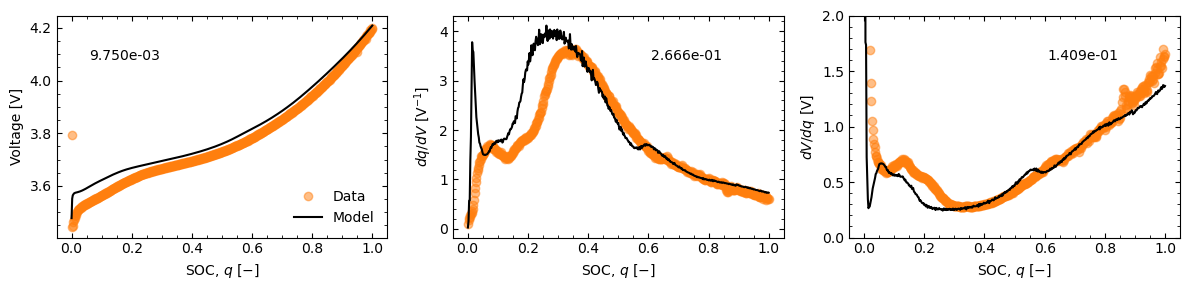

In [4]:
# Set the full-cell data of this Fitter instance
fitter.df_cell = df_cell_BOL

# Run the coarse search to find a decent initial guess for a more precise optimization.
summary1 = fitter.coarse_search(11)
print(_RichResult(**summary1), "\n")
fitter.plot(summary1['x'], dvdq_ylims=[0, 2])

### Constrained fits

The 'constrained_fit()' method executes a routine from scipy.optimize to find values of xmin/xmax (and and iR offset if 'voltage' is in 'cost_terms'). The routine forces xmax > xmin for each electrode and sets bounds (+/-) on each xmin and xmax based on the 'fitter.bounds' attributes. See the docstrings for more information and detail.

The 'constrained_fit()' method takes in a starting guess. You can pass the summary from the 'coarse_search()' if you ran one. Otherwise, you can start with the 'constrained_fit()' routine right way and pass the output from a previous routine back in to see if the fit continues to improve.

 message: `xtol` termination condition is satisfied.
 success: True
     fun: 0.12054204513700983
       x: [ 3.911e-02  8.252e-01  1.755e-02  9.036e-01  8.224e-19]
    nfev: 2568
   niter: 294
   x_map: ['x0_neg', 'x100_neg', 'x0_pos', 'x100_pos', 'iR'] 



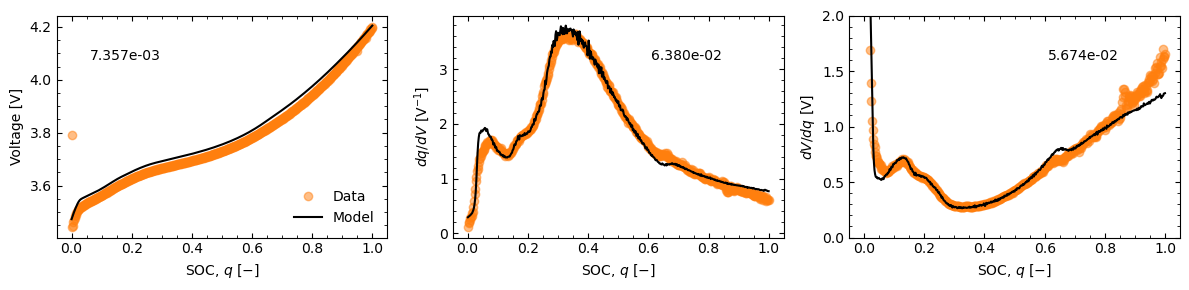

In [5]:
summary2 = fitter.constrained_fit(summary1['x'])
print(_RichResult(**summary2), "\n")
fitter.plot(summary2['x'], dvdq_ylims=[0, 2])

### Fitting voltage-capacity curves throughout cell lifetime
There is no need to create a 'fitter' instance for multiple files if you are batch processing data. Instead, fit the full cell data starting at beggining of life (BOL) and moving toward end of life (EOL). A guess from the previous previous best fit is typically good enough that there is no need to re-run a 'coarse_search()' routine.

 message: `xtol` termination condition is satisfied.
 success: True
     fun: 0.08362792214471013
       x: [ 5.774e-03  7.390e-01  3.821e-03  9.161e-01  9.739e-19]
    nfev: 4812
   niter: 529
   x_map: ['x0_neg', 'x100_neg', 'x0_pos', 'x100_pos', 'iR'] 



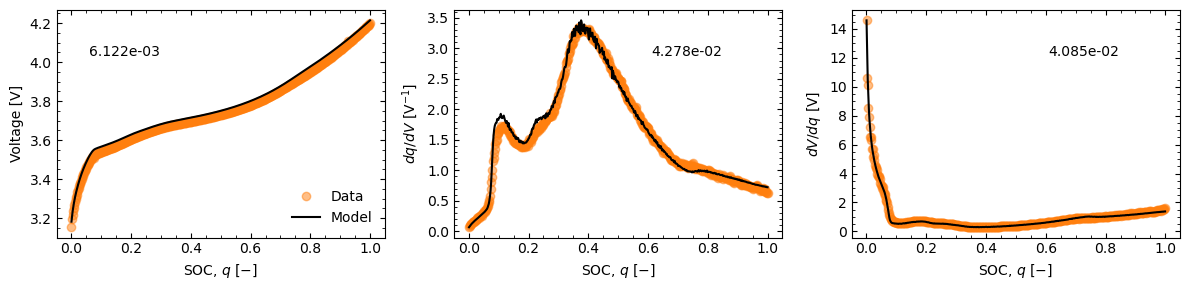

In [6]:
fitter.df_cell = df_cell_EOL

summary3 = fitter.constrained_fit(summary2['x'])
print(_RichResult(**summary3), "\n")
fitter.plot(summary3['x'])

### Using a GUI
You can run the following command to launch a GUI to do the fits one at a time, manually. It is relatively straight forward to understand and use, but is not indendend for batch processing, so is slow if you have many curves to fit.

In [8]:
amp.dqdv.run_gui()

KeyboardInterrupt: 

SystemExit: 0